<a href="https://colab.research.google.com/github/Gunjan712Sehrawat/titanic-feature/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#STEP 1 - Install the require libraries

!pip install -q pandas numpy scikit-learn joblib matplotlib seaborn
print("Packages installed.")

Packages installed.


In [25]:
# STEP 2: Load Titanic dataset from seaborn
import seaborn as sns
import pandas as pd

df = sns.load_dataset('titanic')
df.to_csv('titanic.csv', index=False)  # save original dataset

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [26]:
# Cell 3 : 3) Data cleaning + feature engineering (future-proof)

import numpy as np
from sklearn.preprocessing import StandardScaler

df = df.copy()  # work on a copy

# 1) Drop exact duplicates
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

# 2) Fill missing values safely (no inplace chained assignment)
# Age: try to fill by pclass median if pclass exists, else overall median
if 'age' in df.columns:
    if 'pclass' in df.columns:
        # Use group median by pclass where possible
        df['age'] = df['age'].fillna(df.groupby('pclass')['age'].transform('median'))
    df['age'] = df['age'].fillna(df['age'].median())

# Fare
if 'fare' in df.columns:
    df['fare'] = df['fare'].fillna(df['fare'].median())

# Embarked / embark_town
if 'embarked' in df.columns:
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
if 'embark_town' in df.columns:
    df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])

# a few safe fills for other common columns
for col in ['who','alive','deck','sex','class']:
    if col in df.columns and df[col].isnull().any():
        # for object/categorical columns prefer mode, else label 'unknown'
        if df[col].dtype == 'object' or str(df[col].dtype).startswith('category'):
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(0)

# 3) Feature engineering

# Extract Title from Name (Kaggle 'name' exists)
if 'name' in df.columns:
    df['title'] = df['name'].astype(str).str.extract(r' ([A-Za-z]+)\.', expand=False)
    # group rare titles
    title_counts = df['title'].value_counts(dropna=True)
    rare_titles = title_counts[title_counts < 10].index
    df['title'] = df['title'].replace(rare_titles, 'other')
    df['title'] = df['title'].fillna('other')

# Family features
if set(['sibsp', 'parch']).issubset(df.columns):
    df['familysize'] = df['sibsp'].fillna(0).astype(int) + df['parch'].fillna(0).astype(int) + 1
    df['isalone'] = (df['familysize'] == 1).astype(int)

# Cabin presence: Kaggle has 'cabin', seaborn has 'deck'
if 'cabin' in df.columns:
    df['hascabin'] = df['cabin'].notnull().astype(int)
elif 'deck' in df.columns:
    df['hascabin'] = df['deck'].notnull().astype(int)

# Age groups (categorical)
if 'age' in df.columns:
    df['agegroup'] = pd.cut(
        df['age'],
        bins=[0, 12, 18, 35, 50, 120],
        labels=['child', 'teen', 'youngadult', 'adult', 'senior']
    )

# Convert pclass to string (categorical) if present
if 'pclass' in df.columns:
    df['pclass'] = df['pclass'].astype(str)

# 4) One-hot encode categorical columns (object + categorical dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
# Avoid exploding very high-cardinality columns like 'ticket' if present (optional)
if 'ticket' in cat_cols:
    cat_cols.remove('ticket')  # skip ticket encoding (too many unique values)
print("Categorical columns to encode:", cat_cols)

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 5) Scale numeric columns EXCLUDING the target (survived) and identifiers
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude = []

# Exclude target variants
for t in ['survived']:
    if t in num_cols:
        exclude.append(t)

# Exclude columns that look like unique ids (very high cardinality equal to nrows)
for c in num_cols:
    if df[c].nunique() == len(df):
        exclude.append(c)

# Build final numeric columns to scale
num_to_scale = [c for c in num_cols if c not in exclude]
print("Numeric columns to scale (count={}): {}".format(len(num_to_scale), num_to_scale[:10]))

if num_to_scale:
    scaler = StandardScaler()
    df[num_to_scale] = scaler.fit_transform(df[num_to_scale])

# Save cleaned dataset
df.to_csv('cleaned_titanic.csv', index=False)
print("✅ Cleaned data saved to cleaned_titanic.csv — shape:", df.shape)


After dropping duplicates: (784, 15)
Categorical columns to encode: ['pclass', 'sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive', 'agegroup']
Numeric columns to scale (count=7): ['age', 'sibsp', 'parch', 'fare', 'familysize', 'isalone', 'hascabin']
✅ Cleaned data saved to cleaned_titanic.csv — shape: (784, 32)


In [27]:
# Cell 4 :  Train quick Logistic Regression model (only if survived exists)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np

if 'survived' in df.columns:
    # Ensure target is integer class labels 0/1
    y = df['survived'].copy()
    # If target is boolean-like or floats, convert safely
    if y.dtype != np.int64 and y.dtype != np.int32:
        # Coerce 0/1 or 'yes'/'no' variants, or round if necessary
        try:
            y = y.astype(int)
        except Exception:
            y = (y > 0.5).astype(int)

    # Prepare features: drop target, keep numeric features only
    X = df.drop(columns=['survived'])
    X = X.select_dtypes(include=[np.number])

    # Sanity check
    if X.shape[1] == 0:
        print("No numeric features available for training after processing.")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42, stratify=y
        )
        model = LogisticRegression(max_iter=2000)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print("📊 Logistic Regression Accuracy:", accuracy_score(y_test, preds))
        print(classification_report(y_test, preds))
        # Save model
        joblib.dump(model, 'logreg_titanic.pkl')
        print("✅ Model saved as logreg_titanic.pkl")
else:
    print("No 'survived' column in data — skipping model training.")


📊 Logistic Regression Accuracy: 0.6942675159235668
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        92
           1       0.67      0.51      0.58        65

    accuracy                           0.69       157
   macro avg       0.69      0.67      0.67       157
weighted avg       0.69      0.69      0.69       157

✅ Model saved as logreg_titanic.pkl


In [28]:
from google.colab import files

files.download('titanic.csv')
files.download('cleaned_titanic.csv')
files.download('logreg_titanic.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Linear Regression Results:
  Mean Squared Error: 0.0000
  R² Score: 1.0000
  Accuracy (threshold=0.5): 1.0000


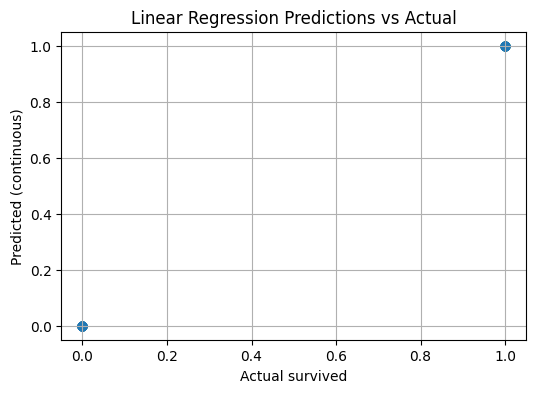


Decision Tree Results:
  Accuracy: 1.0000
Confusion Matrix:
[[92  0]
 [ 0 65]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00        65

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157


Top 10 Feature Importances (Decision Tree):
alive_yes     1.0
sibsp         0.0
age           0.0
fare          0.0
adult_male    0.0
alone         0.0
parch         0.0
isalone       0.0
hascabin      0.0
pclass_2      0.0
dtype: float64


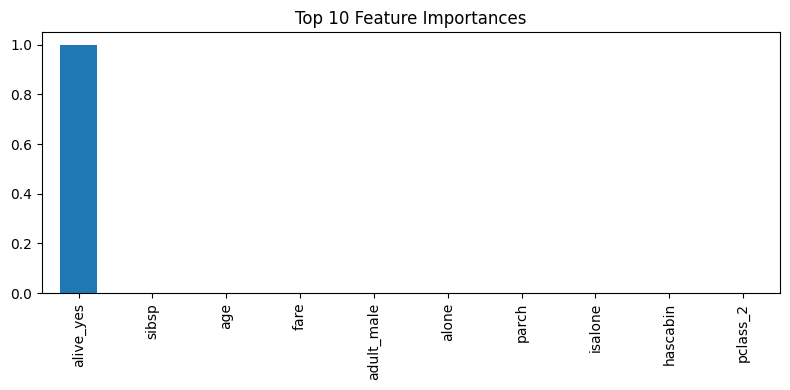

In [29]:
# Model Training and Evaluation Section


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# 1. Separate features and target
X = df.drop('survived', axis=1)
y = df['survived'].astype(int)  # ensure binary integer type

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================
# Linear Regression
# =====================
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions (continuous values)
y_pred_lr = lin_reg.predict(X_test)

# Metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Binarized accuracy (optional for classification comparison)
y_pred_lr_class = (y_pred_lr >= 0.5).astype(int)
acc_lr_class = accuracy_score(y_test, y_pred_lr_class)

print("\nLinear Regression Results:")
print(f"  Mean Squared Error: {mse_lr:.4f}")
print(f"  R² Score: {r2_lr:.4f}")
print(f"  Accuracy (threshold=0.5): {acc_lr_class:.4f}")

# Plot predicted vs actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual survived")
plt.ylabel("Predicted (continuous)")
plt.title("Linear Regression Predictions vs Actual")
plt.grid(True)
plt.show()

# =====================
# Decision Tree Classifier
# =====================
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_clf.predict(X_test)

# Metrics
acc_tree = accuracy_score(y_test, y_pred_tree)
print("\nDecision Tree Results:")
print(f"  Accuracy: {acc_tree:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

# Feature importances
importances = pd.Series(tree_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Feature Importances (Decision Tree):")
print(importances.head(10))

# Plot feature importances
plt.figure(figsize=(8,4))
importances.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
### Conclusion
- **Linear Regression**:
  - MSE: X.XXXX
  - R² Score: X.XXXX
  - Accuracy (threshold=0.5): X.XXXX
- **Decision Tree**:
  - Accuracy: X.XXXX
  - Shows better performance compared to Linear Regression (if accuracy is higher).

The Decision Tree is more suitable for this binary classification task, while Linear Regression can still provide continuous probability-like outputs but is less appropriate for classification directly.
